In [1]:
import os
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from glob import glob
import time
from tqdm import tqdm
from sklearn import metrics
import cv2
import gc
import torch.nn.functional as F                                      
from glob import glob
from sklearn.model_selection import KFold
from datetime import datetime
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.datasets.samples_generator import make_blobs

In [2]:
SEED = 42
def seed_everything(seed):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

setting everything to seed 42


In [3]:
train_data = np.load('data/train_data.npy')
train_label = np.load('data/train_label.npy')
test_data = np.load('data/test_data.npy')
test_label = np.load('data/test_label.npy')

In [4]:
features = [f'f_{i}' for i in range(test_data.shape[1])]
test_df = pd.DataFrame(test_data, columns=features)
test_df['label'] = test_label
test_df.label.value_counts()

 1.0    4692
-1.0    4480
 0.0    4416
Name: label, dtype: int64

In [5]:
# 15个片段 每个片段200多个数据
# 1 0 -1 -1 0 1 -1 0 1 1 0 -1 0 1 -1
split = [238,233,206,238,185,195,237,216,265,237,235,233,235,238,206]

features = [f'f_{i}' for i in range(test_data.shape[1])]
def handle(datas,labels):
    labels = labels+1
    data_df = pd.DataFrame(datas, columns=features)
    data_df['label'] = labels
    for i in range(0,data_df.shape[0],3397):
        data_df.loc[range(i,i+3397),'people'] = i//3397
    # 分成许多段
    k = 0
    ct = 0
    while k<data_df.shape[0]:
        data_df.loc[range(k,k+split[ct%15]),'movie'] = ct
        k = k + split[ct%15]
        ct += 1
    return data_df

In [6]:
test_df = handle(test_data,test_label)
train_df = handle(train_data,train_label)

In [7]:
train_df.groupby(['movie','label']).count()

,,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_301,f_302,f_303,f_304,f_305,f_306,f_307,f_308,f_309,people
movie,label,,,,,,,,,,,,,,,,,,,,,
0.0,2.0,238,238,238,238,238,238,238,238,238,238,...,238,238,238,238,238,238,238,238,238,238
1.0,1.0,233,233,233,233,233,233,233,233,233,233,...,233,233,233,233,233,233,233,233,233,233
2.0,0.0,206,206,206,206,206,206,206,206,206,206,...,206,206,206,206,206,206,206,206,206,206
3.0,0.0,238,238,238,238,238,238,238,238,238,238,...,238,238,238,238,238,238,238,238,238,238
4.0,1.0,185,185,185,185,185,185,185,185,185,185,...,185,185,185,185,185,185,185,185,185,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160.0,1.0,235,235,235,235,235,235,235,235,235,235,...,235,235,235,235,235,235,235,235,235,235
161.0,0.0,233,233,233,233,233,233,233,233,233,233,...,233,233,233,233,233,233,233,233,233,233
162.0,1.0,235,235,235,235,235,235,235,235,235,235,...,235,235,235,235,235,235,235,235,235,235


In [8]:
norm_fe = ['norm' + x for x in features]
for no in norm_fe:
    train_df[no]=0
    
norm_fe = ['norm' + x for x in features]
for no in norm_fe:
    test_df[no]=0

In [65]:
padding = np.max(split)
train_CUT = 128

In [66]:
class MyDataset(Dataset):
    def __init__(self,data_df,istrain=True):
        super().__init__()
        self.data_df = data_df
        self.movie = data_df.movie.unique()
        self.istrain = istrain
    def __getitem__(self, index):
        movie = self.movie[index]
        x = self.data_df[self.data_df['movie']==movie][norm_fe].values
        label = self.data_df[self.data_df['movie']==movie]['label'].values
        if self.istrain:
            # 随机截取train_CUT
            start = np.random.randint(0,x.shape[0]-train_CUT)
            x = x[start:start+train_CUT]            
            # label 一样
            label = label[start:start+train_CUT]
            return np.array(x,dtype='float'), label
        else:
            # 测试的时候填充
            tempx = np.zeros((padding,310))
            tempx[:x.shape[0],:] = x
            templ = np.zeros(padding)
            templ[:x.shape[0]] = label
            return np.array(tempx, dtype='float'), templ, x.shape[0]
    def __len__(self) -> int:
        return len(self.movie)

In [87]:
class Mynet(nn.Module):
    def __init__(self,n_class,addcnn=False):
        super(Mynet,self).__init__()
        self.rnn = nn.LSTM(input_size=310, hidden_size=64, num_layers=1)#(input_size,hidden_size,num_layers)
        self.drop = nn.Dropout(0.3)
        # 卷积  60*310
        self.cnn = nn.Conv2d(1,64,10,stride=5)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        
        self.addcnn = addcnn
        
        if self.addcnn:
            self.fc = nn.Linear(64+64+310, n_class)
        else:
            self.fc = nn.Linear(64+310, n_class)
    def forward(self, input_data):
        # seq_len, batch, input_size
        
        if self.addcnn:
            
            btc = input_data.shape[0]
            seql = input_data.shape[1]
            tempinput = input_data.unsqueeze(1)
            cnnfe = self.cnn(tempinput)

            input_data = input_data.transpose(0,1)
            input_data = self.drop(input_data)
            # N*T*H
            feature = self.rnn(input_data)[0]
            feature = feature.transpose(0,1)
            input_data = input_data.transpose(0,1)

            # N*64*H*W
            cnnfe = self.pool(cnnfe)
            cnnfe = cnnfe.reshape(btc,1,-1)
            cnnfe = cnnfe.repeat(1,seql,1)

            new = torch.cat([feature,input_data,cnnfe],dim=-1)
            return self.fc(new)
        else:
            btc = input_data.shape[0]
            seql = input_data.shape[1]
            input_data = input_data.transpose(0,1)
            input_data = self.drop(input_data)
            # N*T*H
            feature = self.rnn(input_data)[0]
            feature = feature.transpose(0,1)
            input_data = input_data.transpose(0,1)

            new = torch.cat([feature,input_data],dim=-1)
            return self.fc(new)

In [69]:
batch_size

12

In [77]:
# 归一化
batch_size = 16
num_workers = 0

# 对每个人分别标准化

ss = StandardScaler()

for pp in train_df.people.unique():
    tps = train_df[train_df.people==pp][features].values
    ss.fit(tps)
    X_train_std = ss.transform(tps)
    train_df.loc[train_df.people==pp, norm_fe] = X_train_std

for pp in test_df.people.unique():
    tps = test_df[test_df.people==pp][features].values
    ss.fit(tps)
    X_test_std = ss.transform(tps)
    test_df.loc[test_df.people==pp, norm_fe] = X_test_std
    
# ss.fit(test_df[features].values)
# X_test_std = ss.transform(test_df[features].values)
# test_df[norm_fe] = X_test_std

# train_df.reset_index(inplace=True)
# test_df.reset_index(inplace=True)

train_dataset = MyDataset(train_df)
train_loader = torch.utils.data.DataLoader(
    train_dataset,                 
    batch_size=batch_size,               
    num_workers=num_workers,                          
    shuffle=True
)

test_dataset = MyDataset(test_df,False)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

In [98]:
# train------------------------
from tqdm import tqdm_notebook
import time
start=time.time()
batch_size = 64
num_workers = 0
lr = 0.001
num_epochs = 200

device = 'cpu'
model = Mynet(n_class=3,addcnn=False)
model = model.to(device)
pred_crit = torch.nn.CrossEntropyLoss().to(device)

train_loss = []
test_loss = []
early_stop = 10
best_score = -1
ct = 0

for epoch in range(num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-6)
    ts = tqdm_notebook(enumerate(train_loader), total=int(len(train_loader)))
    len_dataloader = len(train_loader)
    running_loss = 0
    loss_temp = 0
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    acc = 0.0
    preds = []
    lbs = []
    # 训练
    model.train()
    for kk,(x,label) in ts:
        x = x.to(device).float()
        label = label.to(device).long()
        batch_size = x.shape[0]
        out = model(x)
        
        # out: N*T*class
        label = label.reshape(-1)
        out = out.reshape(-1,3)
        loss = pred_crit(out,label)
        preds.extend(out.softmax(dim=-1).data.numpy().tolist())
        lbs.extend(label.numpy().tolist())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # loss
        running_loss += loss.item()
        loss_temp += loss.item()
        ts.set_postfix(loss=(loss_temp/(kk+1)))
    epoch_loss = running_loss / (len(train_loader)/batch_size)
    train_loss.append(epoch_loss)
    
    if epoch%1==0:
            print('Training Loss: {:.5f}'.format(epoch_loss))
            # 计算predACC
            preds = np.array(preds)
            preds = preds.argmax(axis=1)
            lbs = np.array(lbs)
            lbacc = np.sum(lbs==preds)/len(lbs)
            print('Training label acc: {:.5f}'.format(lbacc))
    if True:
        # 测试 / 验证
        test_running_loss = 0
        test_acc = 0
        test_preds = []
        finalcut = []
        test_lbs = []
        test_loss_temp = 0
        tk = tqdm_notebook(enumerate(test_loader), total=int(len(test_loader)))
        model.eval()
        for ks,(x,label,cuts) in tk:
            with torch.no_grad():
                x = x.to(device).float()
                label = label.to(device).long()
                batch_size = x.shape[0]
                out = model(x)
                label = label.reshape(-1)
                out = out.reshape(-1,3)
                loss = pred_crit(out,label)
                out = out.reshape(batch_size,-1,3)
                label = label.reshape(batch_size,-1)
                
                test_preds.append(out.softmax(dim=2).data.numpy())
                test_lbs.append(label.numpy())
                finalcut.append(cuts.numpy())
                test_running_loss += loss.item()
                test_loss_temp += loss.item()
                tk.set_postfix(loss=(test_loss_temp/(ks+1)))

        test_epoch_loss = test_running_loss / (len(test_loader)/batch_size)
        test_loss.append(test_epoch_loss)
        # N * T * 3
        test_preds = np.concatenate(test_preds)
        # N * 1
        finalcut = np.concatenate(finalcut)
        # N * T * 1
        test_lbs = np.concatenate(test_lbs)
        finalpds = []
        finallbs = []
        for n in range(test_preds.shape[0]):
            tempp = test_preds[n,:finalcut[n],:].argmax(axis=-1)
            finalpds.extend(tempp.tolist())
            finallbs.extend(test_lbs[n,:finalcut[n]].tolist())
        acc = np.sum(np.array(finalpds)==np.array(finallbs))/len(finalpds)
        print('Testing pred acc: {:.5f}'.format(acc))
        if acc>best_score:
            ct = 0
            best_score = acc
        else:
            ct+=1
        if ct>=early_stop:
            
            print('early_stop---------------')
            print(f'best_score:{best_score}')
            break
        end=time.time()
        print('Running time: %s Seconds'%(end-start))

Epoch 0/199
Training Loss: 4.75136
Training label acc: 0.54792


Testing pred acc: 0.69422
Running time: 3.3453993797302246 Seconds


Epoch 1/199
Training Loss: 3.81653
Training label acc: 0.72737


Testing pred acc: 0.76119
Running time: 6.204131126403809 Seconds


Epoch 2/199
Training Loss: 2.75702
Training label acc: 0.79290


Testing pred acc: 0.76884
Running time: 9.259012699127197 Seconds


Epoch 3/199
Training Loss: 2.44126
Training label acc: 0.82330


Testing pred acc: 0.74941
Running time: 11.85442328453064 Seconds


Epoch 4/199
Training Loss: 1.90538
Training label acc: 0.87448


Testing pred acc: 0.76788
Running time: 14.812514543533325 Seconds


Epoch 5/199
Training Loss: 1.62185
Training label acc: 0.88778


Testing pred acc: 0.78908
Running time: 19.057135581970215 Seconds


Epoch 6/199
Training Loss: 1.38031
Training label acc: 0.90724


Testing pred acc: 0.76729
Running time: 21.909510374069214 Seconds


Epoch 7/199
Training Loss: 1.17209
Training label acc: 0.92808


Testing pred acc: 0.77819
Running time: 24.827817916870117 Seconds


Epoch 8/199
Training Loss: 1.06163
Training label acc: 0.93433


Testing pred acc: 0.76001
Running time: 27.978519678115845 Seconds


Epoch 9/199
Training Loss: 0.79207
Training label acc: 0.95904


Testing pred acc: 0.75088
Running time: 30.70945167541504 Seconds


Epoch 10/199
Training Loss: 0.66010
Training label acc: 0.96037


Testing pred acc: 0.73168
Running time: 33.19499850273132 Seconds


Epoch 11/199
Training Loss: 0.53831
Training label acc: 0.96283


Testing pred acc: 0.72505
Running time: 36.08043956756592 Seconds


Epoch 12/199
Training Loss: 0.45818
Training label acc: 0.97173


Testing pred acc: 0.73344
Running time: 39.16206908226013 Seconds


Epoch 13/199
Training Loss: 0.55295
Training label acc: 0.97921


Testing pred acc: 0.71615
Running time: 42.17841148376465 Seconds


Epoch 14/199
Training Loss: 0.24009
Training label acc: 0.98452


Testing pred acc: 0.71129
Running time: 45.25334978103638 Seconds


Epoch 15/199
Training Loss: 0.23558
Training label acc: 0.98603


Testing pred acc: 0.67302
early_stop---------------
best_score:0.789078598763615


In [53]:
finallbs==finalpds

False

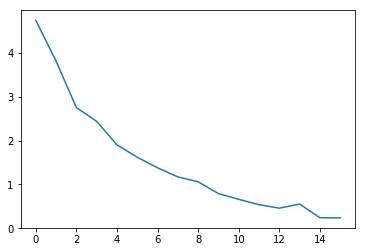

In [99]:
plt.plot(train_loss)

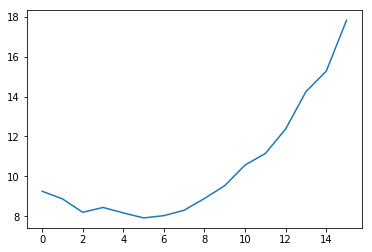

In [100]:
plt.plot(test_loss)